# Emerging Technologies
---

## Introduction

--- 

In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt

## Problem 1: Generating Random Boolean Functions
>The Deutsch–Jozsa algorithm is designed to work with functions that accept a fixed number of Boolean inputs and return a single Boolean output. Each function is guaranteed to be either constant (always returns False or always returns True) or balanced (returns True for exactly half of the possible input combinations). Write a Python function random_constant_balanced that returns a randomly chosen function from the set of constant or balanced functions taking four Boolean arguments as inputs.

The Deutsch-Jozsa algorithm, proposed by David Deutsch and Richard Jozsa in 1992, was one of the first examples demonstrating a quantum algorithm's exponential speedup over any deterministic classical algorithm. The problem involves a black-box function (an "oracle"), $f$, which takes an $n$-bit binary string as input and returns a single bit:

$$
f: \{0,1\}^n \rightarrow \{0,1\}
$$

The problem guarantees (promises) that $f$ belongs to one of two strictly defined categories:

- **Constant**: The output is the same (0 or 1) for all possible input strings.
- **Balanced**: The output is 0 for exactly half of the inputs and 1 for the other half.

See [this IBM course section](https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/quantum-query-algorithms/deutsch-jozsa-algorithm) for a more detailed overview of the Deutsch-Jozsa algorithm. 

For this problem, we are simulating an oracle with $n=4$ bits. This creates an input space of size $N = 2^4 = 16$.

To simulate this classically, I have implemented a generator in Python that:

- **Randomly Selects the Type**: Uses a uniform random choice to decide if the function is constant or balanced.
- **Constructs the Truth Table**:
    - Constant: An array of size 16 filled with all `False` or all `True`.
    - Balanced: An array containing eight `False` and eight `True` values, which is then shuffled using `numpy.random.shuffle`.
- **Encapsulates Logic**: The function returns a callable oracle object. This object maps the 4 input bits $(a, b, c, d)$ to an integer index (0–15) to retrieve the pre-calculated output, effectively hiding the internal state from the user.

In [2]:
def random_constant_balanced():
    """
    Generate a random constant or balanced Boolean function.
    
    Returns a function f(a, b, c, d) that takes four Boolean arguments
    and returns a Boolean output. The function is guaranteed to be either:
    - Constant: returns the same value for all 16 possible inputs
    - Balanced: returns True for exactly 8 inputs, False for 8 inputs
    
    The returned function has a .type attribute ('Constant' or 'Balanced')
    for verification purposes only.
    
    Returns:
        callable: A function taking four Boolean arguments.
    """
    num_bits = 4
    num_inputs = 2 ** num_bits

    # Randomly choose between constant and balanced.
    is_constant = np.random.randint(0, 2)
    
    if is_constant:
        # Constant: all outputs identical.
        constant_value = bool(np.random.randint(0, 2))
        outputs = np.full(num_inputs, constant_value, dtype=bool)
        function_type = "Constant"
    else:
        # Balanced: exactly half True, half False.
        outputs = np.array(
            [False] * (num_inputs // 2) + [True] * (num_inputs // 2)
        )
        np.random.shuffle(outputs) # Shuffle to randomize the order of True/False
        function_type = "Balanced"

    def oracle(a, b, c, d):
        """
        Evaluate the oracle function.
        
        Maps 4 Boolean arguments to an integer index using binary 
        weighting (8, 4, 2, 1), then uses the pre-computed outputs 
        array as a lookup table.

        Args:
            a (bool): First input bit.
            b (bool): Second input bit.
            c (bool): Third input bit.
            d (bool): Fourth input bit.

        Returns:
            bool: The output of the oracle function for the given inputs.
        """
        index = 8*int(a) + 4*int(b) + 2*int(c) + int(d)
        return outputs[index]
    
    # Attach type for verification purposes
    oracle.type = function_type
    return oracle

To ensure the above function works correctly, we need to verify that every function it creates follows the **Deutsch-Jozsa promise**. This means every function must be either 100% constant or exactly 50/50 balanced.

Since we are using 4 Boolean inputs, there are $2^4 = 16$ possible combinations. The test function below:

1. **Generates all 16 possible inputs**: It covers every combination from `(False, False, False, False)` to `(True, True, True, True)`.
2. **Runs the oracle**: It executes the function for every single combination.
3. **Counts the distribution**: It counts how many times the function returns `True` versus `False`.



A **PASS** is confirmed if:
* **Constant** functions return `True` either 0 times or 16 times.
* **Balanced** functions return `True` exactly 8 times.

In [3]:
def test_random_constant_balanced(oracle_func, input_space):
    """
    Checks the oracle across all 16 inputs to verify the 
    Constant or Balanced distribution.
    
    Args:
        oracle_func: The function to test (must have .type attribute)
        input_space: List of all possible input tuples
        
    Prints:
        PASS/FAIL status with distribution counts
    """
    # Run all inputs and count True/False results
    results = [oracle_func(*input_tuple) for input_tuple in input_space]
    true_count = sum(results)
    false_count = len(input_space) - true_count
    
    # Verify if the counts match the promised type
    if oracle_func.type == "Constant":
        is_valid = (true_count == 0 or true_count == 16)
    else: # Balanced
        is_valid = (true_count == 8)
    
    status = "PASS" if is_valid else "FAIL"
    print(
        f"Result: {status} - Type: {oracle_func.type} - "
        f"True: {true_count}, False: {false_count}"
        )

# Generate all 16 possible combinations (2^4)
# Using itertools.product to create Cartesian product of [False, True] repeated 4 times
# Cartesian product gives all combinations of the input values
# See https://docs.python.org/3/library/itertools.html#itertools.product for more details
bit_combinations = list(itertools.product([False, True], repeat=4))

# Run verification 10 times
for i in range(10):
    current_oracle = random_constant_balanced()
    test_random_constant_balanced(current_oracle, bit_combinations)

Result: PASS - Type: Constant - True: 0, False: 16
Result: PASS - Type: Balanced - True: 8, False: 8
Result: PASS - Type: Balanced - True: 8, False: 8
Result: PASS - Type: Balanced - True: 8, False: 8
Result: PASS - Type: Constant - True: 0, False: 16
Result: PASS - Type: Constant - True: 0, False: 16
Result: PASS - Type: Balanced - True: 8, False: 8
Result: PASS - Type: Balanced - True: 8, False: 8
Result: PASS - Type: Constant - True: 16, False: 0
Result: PASS - Type: Constant - True: 16, False: 0


To confirm the internal logic of the generated oracles, we can inspect them both numerically and visually. This approach ensures that the "Black Box" functions adhere strictly to the **Deutsch-Jozsa Promise** by utilizing tools from the standard data science stack, specifically `pandas` ([documentation](https://pandas.pydata.org/docs/)) and `matplotlib` ([documentation](https://matplotlib.org/stable/index.html)).

The following section generates one sample of each oracle type to display their raw truth tables and digital "signatures."

In [4]:
def get_representative_samples():
    """Generates oracles until both a Constant and Balanced type are obtained."""
    constant_sample = None
    balanced_sample = None
    
    while constant_sample is None or balanced_sample is None:
        new_oracle = random_constant_balanced()
        
        if new_oracle.type == "Constant":
            constant_sample = new_oracle
        else:
            balanced_sample = new_oracle
            
    return constant_sample, balanced_sample

# Setup data for visualization
oracle_c, oracle_b = get_representative_samples()
df_viz = pd.DataFrame(bit_combinations, columns=['A', 'B', 'C', 'D'])

# Unpack input tuples into the oracle using the * operator
df_viz['Constant Oracle'] = [oracle_c(*row) for row in bit_combinations]
df_viz['Balanced Oracle'] = [oracle_b(*row) for row in bit_combinations]

display(df_viz)

,A,B,C,D,Constant Oracle,Balanced Oracle
0,False,False,False,False,False,True
1,False,False,False,True,False,False
2,False,False,True,False,False,True
3,False,False,True,True,False,False
4,False,True,False,False,False,False
5,False,True,False,True,False,False
6,False,True,True,False,False,True
7,False,True,True,True,False,True
8,True,False,False,False,False,True
9,True,False,False,True,False,False


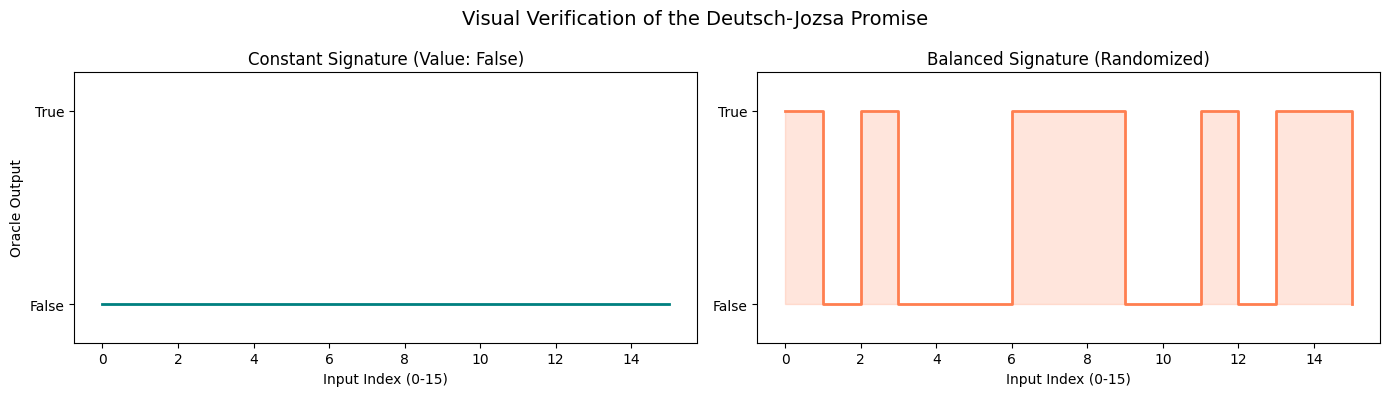

In [5]:
# Visualizing the functional "signatures"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Step plots are used to represent the discrete binary nature of the outputs
ax1.step(range(16), df_viz['Constant Oracle'].astype(int), where='post', color='teal', linewidth=2)
ax1.fill_between(range(16), df_viz['Constant Oracle'].astype(int), step="post", alpha=0.2, color='teal')
ax1.set_title(f"Constant Signature (Value: {df_viz['Constant Oracle'][0]})")

ax2.step(range(16), df_viz['Balanced Oracle'].astype(int), where='post', color='coral', linewidth=2)
ax2.fill_between(range(16), df_viz['Balanced Oracle'].astype(int), step="post", alpha=0.2, color='coral')
ax2.set_title("Balanced Signature (Randomized)")

# Standardizing axes for Boolean comparison
for ax in [ax1, ax2]:
    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['False', 'True'])
    ax.set_xlabel("Input Index (0-15)")

ax1.set_ylabel("Oracle Output")
plt.suptitle("Visual Verification of the Deutsch-Jozsa Promise", fontsize=14)
plt.tight_layout()
plt.show()

---
## Problem 2: Classical Testing for Function Type
>Deutsch's algorithm is designed to demonstrate a potential advantage of quantum computing over classical computation. To understand this advantage, we must first understand the classical cost of solving the underlying problem. Write a Python function determine_constant_balanced that takes as input a function f, as defined in Problem 1. The function should analyze f and return the string "constant" or "balanced" depending on whether the function is constant or balanced. Write a brief note on the efficiency of your solution. What is the maximum number of times you need to call f to be 100% certain whether it is constant or balanced?

To determine with 100% certainty whether a function is Constant or Balanced classically, we must account for the worst-case scenario.

The approach I have taken to solve this problem is by using an "early exit" strategy. This ensures we do not need to check all of the inputs once a definitive conclusion is reached. 

**Maximum Queries Required**: For a 4-bit oracle (16 possible inputs), the maximum number of queries required is:

$$
N_{max} = 2^{n-1} + 1 = 2^{4-1} + 1 = 9
$$

**Why exactly 9 queries?**

A balanced function returns `True` for exactly 8 inputs and `False` for 8 inputs. In the worst case:

- After 8 identical results: The function *could* still be balanced (we might have checked all 8 instances of one value, with the other 8 remaining)
- After 9 identical results: The function *must* be constant (balanced functions only have 8 of each value)

**Best Case**: If the first two queries return different values, we immediately know the function is Balanced, requiring only 2 queries.

**Classical vs Quantum**: This 9-query worst case establishes the classical baseline. The Deutsch-Jozsa quantum algorithm, which we will now look at in the following problems, requires only **1 query** regardless of input size.

In [6]:
def determine_constant_balanced(f):
    """
    Determines whether the given function f is Constant or Balanced.
    
    Uses early termination: stops as soon as it has enough evidence to be 
    100% certain, demonstrating the efficiency limit of classical search.

    Args:
        f (callable): A function that takes four Boolean arguments and 
                      returns a Boolean.
                      
    Returns:
        tuple: A tuple containing:
            - str: "Constant" or "Balanced" based on the analysis of f
            - int: The number of queries made to reach the conclusion
    """
    # bit_combinations defined in Problem 1
    inputs = bit_combinations
    
    # Query the first input
    first_output = f(*inputs[0])
    query_count = 1
    
    # Query remaining inputs (start from the second input)
    for bit_pattern in inputs[1:]:
        current_result = f(*bit_pattern)
        query_count += 1
        
        # If find a different value, definitely Balanced
        if current_result != first_output:
            return "Balanced", query_count
        
        # If 9 identical results, definitely Constant
        # (Balanced functions have exactly 8 of each value)
        if query_count == 9:
            return "Constant", query_count
    
    # All 16 inputs gave the same result, then Constant
    return "Constant", query_count 

To verify the accuracy and efficiency of the `determine_constant_balanced` function, I have implemented a test loop that generates 10 random oracles. This test serves two purposes:

- **Functional Verification**: Ensuring the "Predicted" type matches the "Actual" type of the generated oracle.
- **Efficiency Observation**: Demonstrating that constant functions consistently require 9 queries, while balanced functions are often identified much faster.

In [7]:
print(f"{'Actual Type':<15} | {'Predicted':<15} | {'Queries':<10} | {'PASS/FAIL'}")
print("-" * 60)

all_correct = True
for _ in range(10):
    test_oracle = random_constant_balanced()
    prediction, count = determine_constant_balanced(test_oracle)
    
    is_correct = (test_oracle.type == prediction)
    all_correct = all_correct and is_correct
    
    status = "PASS" if is_correct else "FAIL"
    print(f"{test_oracle.type:<15} | {prediction:<15} | {count:<10} | {status}")

print("\n" + ("All tests passed" if all_correct else "Some tests failed"))

Actual Type     | Predicted       | Queries    | PASS/FAIL
------------------------------------------------------------
Balanced        | Balanced        | 2          | PASS
Balanced        | Balanced        | 2          | PASS
Constant        | Constant        | 9          | PASS
Balanced        | Balanced        | 3          | PASS
Balanced        | Balanced        | 2          | PASS
Balanced        | Balanced        | 4          | PASS
Constant        | Constant        | 9          | PASS
Constant        | Constant        | 9          | PASS
Balanced        | Balanced        | 3          | PASS
Balanced        | Balanced        | 2          | PASS

All tests passed


---
## Problem 3: Quantum Oracles
>Deutsch's algorithm is the simplest example of a quantum algorithm using superposition to determine a global property of a function with a single evaluation. In the single-input case, there are four possible Boolean functions. Using Qiskit, create the appropriate quantum oracles for each of the possible single-Boolean-input functions used in Deutsch's algorithm. Demonstrate their use and explain how each oracle implements its corresponding function.

---
## Problem 4: Deutsch's Algorithm with Qiskit
>Use Qiskit to design a quantum circuit that solves Deutsch's problem for a function with a single Boolean input. Implement the necessary circuit and demonstrate its use with each of the quantum oracles from Problem 3. Describe how the interference pattern produced by the circuit allows you to determine whether the function is constant or balanced using only one query to the oracle.

---
## Problem 5: Scaling to the Deutsch–Jozsa Algorithm
>The Deutsch–Jozsa algorithm generalizes Deutsch's approach to functions with several input bits. Use Qiskit to create a quantum circuit that can handle the four-bit functions generated in Problem 1. Explain how the classical function is encoded as a quantum oracle, and demonstrate the use of your circuit on both of the constant functions and any two balanced functions of your choosing. Show that the circuit correctly identifies the type of each function.

---
## Conclusion

---
# End